In [2]:
import os
from shutil import copyfile, rmtree, move
import pandas as pd
import seaborn as sns
from random import randint, sample
import cv2
from PIL.Image import fromarray
import imgaug.augmenters as iaa
from tqdm.notebook import tqdm
from natsort import natsorted

pwd = os.getcwd()
init_daset_path = pwd + '/data/pep/'
data_folder = pwd  + '/data/'
temp_data_path = data_folder + 'temp_dataset/'
data_path = data_folder + 'dataset/'

# Data prepearing

In [28]:
if not os.path.exists(temp_data_path):
    os.mkdir(temp_data_path)
    os.mkdir(temp_data_path + 'scen1')
    os.mkdir(temp_data_path + 'scen2')
    os.mkdir(temp_data_path + 'scen3')


for scene in os.listdir(init_daset_path):
    for view in os.listdir(init_daset_path + scene):
        for person in os.listdir(init_daset_path + scene + '/' + view):
            if not os.path.exists(temp_data_path + scene + '/' + person):
                os.mkdir(temp_data_path + scene + '/' + person)
            
            for image in os.listdir(init_daset_path + scene + '/' + view + '/' + person):
                copyfile(init_daset_path + scene + '/' + view + '/' + person + '/' + image,
                        temp_data_path + scene + '/' + person + '/' + image)
        


In [2]:
if not os.path.exists(data_path):
    os.mkdir(data_path)

person_n = 0
for scene in os.listdir(temp_data_path):
    for person in os.listdir(temp_data_path + scene):
        if not os.path.exists(data_path + str(person_n)):
            os.mkdir(data_path + str(person_n))
        
        for image in os.listdir(temp_data_path + scene + '/' + person):
            copyfile(temp_data_path + scene + '/' + person + '/' + image, data_path + str(person_n) + '/' + image)
        
        person_n += 1
    

In [3]:
data_dicts = []

for person in os.listdir(data_path):
    for person_photo in os.listdir(data_path + person):
        data_dicts.append({'img': person + '/' + person_photo, 'Y': person})

data = pd.DataFrame(data_dicts)

data.to_csv(data_folder + 'data.csv', index=False)

# Class balancing

In [5]:
data = pd.read_csv(data_folder + 'data.csv')
class_counts = data['Y'].value_counts()

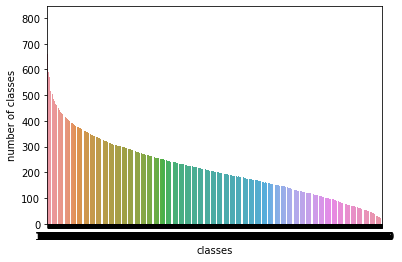

In [6]:
chart = sns.barplot(x=class_counts.index, y=class_counts.sort_values(), order=class_counts.sort_values().index)
chart.set(xlabel='classes', ylabel='number of classes'); 

In [7]:
print('Mean class number: ', round(class_counts.mean()))
print('Median class number: ', round(class_counts.median()))

Mean class number:  216
Median class number:  203


## Minority classes balancing ( < 200 samples )

### Remove classes that has less then 0.25 quantile on amount of sample

In [8]:
min_class_threshold = class_counts[class_counts < 200].quantile(0.25)
print('MIN NUMBER THRESHOLD: ', min_class_threshold)

class_names_to_delete = class_counts[class_counts < min_class_threshold].index

for class_n in class_names_to_delete:
    rmtree(data_path + str(class_n))

class_iter = 0
for class_n in natsorted(os.listdir(data_path)):
    move(data_path + str(class_n), data_path + str(class_iter))
    class_iter += 1

data_dicts = []

for person in os.listdir(data_path):
    for person_photo in os.listdir(data_path + person):
        data_dicts.append({'img': person + '/' + person_photo, 'Y': person})

data = pd.DataFrame(data_dicts)

class_counts = data['Y'].value_counts()

MIN NUMBER THRESHOLD:  82.0


### Upsample other minority class with augmentation up to 200 samples


In [11]:
upsample_numbers = 200 - class_counts[class_counts < 200]

aug = iaa.Sequential([
             iaa.Fliplr(1),
             iaa.GammaContrast((0.75, 1.25)),
             iaa.AddToSaturation((-20, 20)),
             iaa.Crop(percent=(0.03, 0.065), keep_size=True)
            ])

for class_n, upsample_n in tqdm(upsample_numbers.iteritems(), total=len(upsample_numbers)):
    person_path = data_path + str(class_n) + '/'
    all_images = os.listdir(person_path)
    for it in range(upsample_n):
        img_name = all_images[randint(0, len(all_images) - 1)]
        image_orgin = cv2.imread(person_path + img_name)

        image = aug(image=image_orgin)

        save_name = 'aug_' + img_name
        c = 0
        while os.path.exists(person_path + save_name):
            save_name = str(c) + '_aug_' + img_name
            c += 1

        cv2.imwrite(person_path + save_name, image)

data_dicts = []
for class_n in os.listdir(data_path):
    for img in os.listdir(data_path + class_n):
        data_dicts.append({'img': class_n + '/' + img, 'Y': class_n})

data = pd.DataFrame(data_dicts)

class_counts = data['Y'].value_counts()



  0%|          | 0/1004 [00:00<?, ?it/s]

### Majority class balancing ( > 200 samples)
Downsample up to 200 samples on each class


In [17]:
downsample_numbers = class_counts[class_counts > 200].apply(lambda x: x - 200)

deleted_images = []

for class_n, downsample_n in tqdm(downsample_numbers.iteritems(), total=len(downsample_numbers)):
    person_path = data_path + str(class_n) + '/'
    all_images = os.listdir(person_path)
    to_delete = sample(all_images, downsample_n)

    for img_name in to_delete:    
        os.remove(person_path + img_name)

data_dicts = []
for person in os.listdir(data_path):
    for person_photo in os.listdir(data_path + person):
        data_dicts.append({'img': person + '/' + person_photo, 'Y': person})
data = pd.DataFrame(data_dicts)

class_counts = data['Y'].value_counts()

  0%|          | 0/1386 [00:00<?, ?it/s]

In [29]:
data.sample(frac=1.0).to_csv(data_folder + 'data.csv', index=False)

In [19]:
data = pd.read_csv(data_folder + 'data.csv')
class_counts = data['Y'].value_counts()

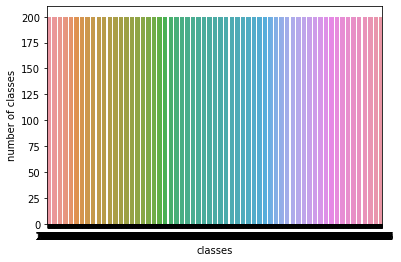

In [26]:
chart = sns.barplot(x=class_counts.index, y=class_counts.sort_values(), order=class_counts.sort_values().index)
chart.set(xlabel='classes', ylabel='number of classes');

In [ ]:
# scp -P 221 /Users/timurk/projects/people_identification/data/dataset.zip kutsenko-t@10.10.94.113:/home/NIX/kutsenko-t/metric_learning